core           INFO 	Loading data for Italian Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
c:\Users\dilau\Desktop\TeamProjF1\fasftF1\.venv\Lib\site-pack

HAM and VER were within 100m or 1 second of each other during lap 5.
Time difference at 1000m: -0.07 seconds
Time difference at 2000m: -0.29 seconds


c:\Users\dilau\Desktop\TeamProjF1\fasftF1\.venv\Lib\site-packages\fastf1\core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


Distance traveled before pit stop: 5483.46 meters
Distance traveled after pit stop: 5773.93 meters


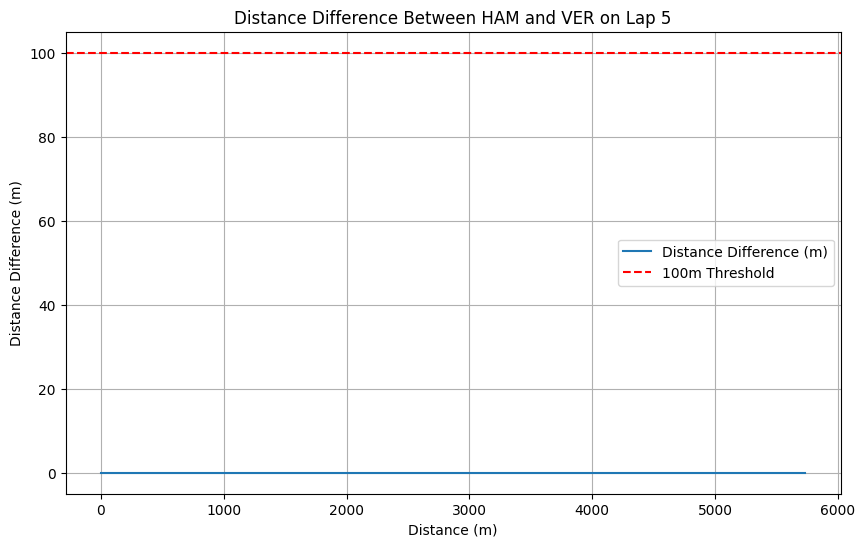

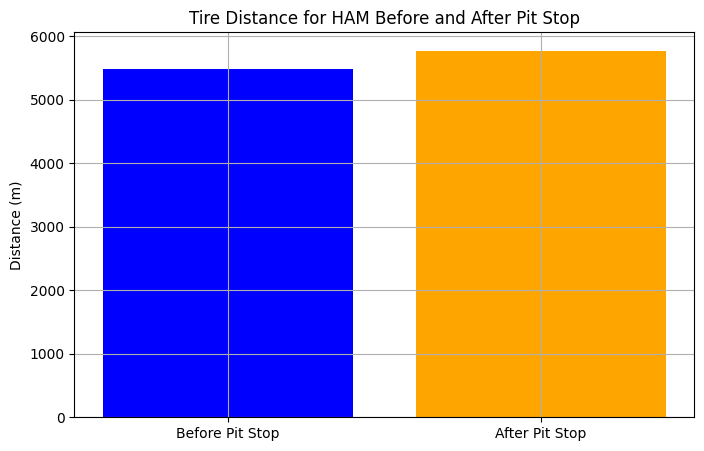

In [20]:
import fastf1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Enable cache (optional)
# fastf1.Cache.enable_cache('cache')

# Define the session details  
year = 2024
gran_prix = "Monza"
sessionG = 'R'  # Race session
driver1 = "HAM"  # Driver N1
driver2 = "VER"  # Driver N2
lap_number = 5  # Lap to analyze

# Load the race session
session = fastf1.get_session(year, gran_prix, sessionG)
session.load()

# Get the laps for both drivers
lap1 = session.laps.pick_driver(driver1).pick_lap(lap_number).iloc[0]
lap2 = session.laps.pick_driver(driver2).pick_lap(lap_number).iloc[0]

# Get telemetry data for both laps
telemetry1 = lap1.get_telemetry()
telemetry2 = lap2.get_telemetry()

# Align telemetry data based on distance using np.interp
common_distance = np.linspace(
    max(telemetry1["Distance"].min(), telemetry2["Distance"].min()),
    min(telemetry1["Distance"].max(), telemetry2["Distance"].max()),
    num=min(len(telemetry1), len(telemetry2))
)

# Interpolate time and other telemetry data for both drivers
time1_interp = np.interp(common_distance, telemetry1["Distance"], telemetry1["Time"].astype(np.int64))
time2_interp = np.interp(common_distance, telemetry2["Distance"], telemetry2["Time"].astype(np.int64))

# Convert time back to timedelta
time1_interp = pd.to_timedelta(time1_interp)
time2_interp = pd.to_timedelta(time2_interp)

# Calculate the difference in distance and time using the interpolated data
distance_diff = np.abs(np.interp(common_distance, telemetry1["Distance"], telemetry1["Distance"]) -
                       np.interp(common_distance, telemetry2["Distance"], telemetry2["Distance"]))
time_diff = np.abs(time1_interp - time2_interp).total_seconds()

# Check if the difference is less than 100m or 1 second
close_moments = (time_diff < 1)

# Print the result
if close_moments.any():
    print(f"{driver1} and {driver2} were within 100m or 1 second of each other during lap {lap_number}.")
else:
    print(f"{driver1} and {driver2} were NOT within 100m or 1 second of each other during lap {lap_number}.")

# Define the two points on the track (in meters)
x1 = 1000  # First point (e.g., 1000m into the lap)
x2 = 2000  # Second point (e.g., 2000m into the lap)

# Get the time at x1 and x2 for both drivers
time1_x1 = telemetry1[telemetry1["Distance"] >= x1].iloc[0]["Time"]
time1_x2 = telemetry1[telemetry1["Distance"] >= x2].iloc[0]["Time"]

time2_x1 = telemetry2[telemetry2["Distance"] >= x1].iloc[0]["Time"]
time2_x2 = telemetry2[telemetry2["Distance"] >= x2].iloc[0]["Time"]

# Calculate the time difference at x1 and x2
time_diff_x1 = (time1_x1 - time2_x1).total_seconds()
time_diff_x2 = (time1_x2 - time2_x2).total_seconds()

# Print the results
print(f"Time difference at {x1}m: {time_diff_x1:.2f} seconds")
print(f"Time difference at {x2}m: {time_diff_x2:.2f} seconds")

# Get all laps for the driver
driver_laps = session.laps.pick_driver(driver1)

# Identify the stint where the pit stop occurred
stints = driver_laps.groupby("Stint")
for stint, stint_laps in stints:
    if stint_laps["PitInTime"].notna().any():  # Check if there was a pit stop in this stint
        pit_stint = stint
        break

# Get telemetry data for the stint before the pit stop
stint_before_pit = driver_laps[driver_laps["Stint"] == pit_stint]
telemetry_before_pit = stint_before_pit.iloc[0].get_telemetry()

# Get telemetry data for the stint after the pit stop
stint_after_pit = driver_laps[driver_laps["Stint"] == pit_stint + 1]
telemetry_after_pit = stint_after_pit.iloc[0].get_telemetry()

# Calculate distance traveled before and after the pit stop
distance_before_pit = telemetry_before_pit["Distance"].max() - telemetry_before_pit["Distance"].min()
distance_after_pit = telemetry_after_pit["Distance"].max() - telemetry_after_pit["Distance"].min()

# Print the results
print(f"Distance traveled before pit stop: {distance_before_pit:.2f} meters")
print(f"Distance traveled after pit stop: {distance_after_pit:.2f} meters")

# Plot distance difference between drivers
plt.figure(figsize=(10, 6))
plt.plot(common_distance, distance_diff, label="Distance Difference (m)")
plt.axhline(100, color="red", linestyle="--", label="100m Threshold")
plt.xlabel("Distance (m)")
plt.ylabel("Distance Difference (m)")
plt.title(f"Distance Difference Between {driver1} and {driver2} on Lap {lap_number}")
plt.legend()
plt.grid()
plt.show()

# Plot tire distance before and after pit stop
plt.figure(figsize=(8, 5))
plt.bar(["Before Pit Stop", "After Pit Stop"], [distance_before_pit, distance_after_pit], color=["blue", "orange"])
plt.ylabel("Distance (m)")
plt.title(f"Tire Distance for {driver1} Before and After Pit Stop")
plt.grid()
plt.show()